In [3]:
import os
import numpy as np
import cv2
import json
from pathlib import Path
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torchvision.utils import make_grid



In [83]:
from matplotlib.pyplot import imshow, figure
import matplotlib as mpl

def view_image(ii, dpi=100, nrow=4):
    mpl.rcParams['figure.dpi'] = dpi
    if len(ii.shape) == 3:        
        imshow(ii)
        return
    t = torch.from_numpy(ii)
    t = t.permute(0, 3, 1, 2)
    n = make_grid(t,padding=4,pad_value=255, nrow=nrow)
    imshow(n.numpy().transpose(1,2,0))

def view_gray(ii, dpi=100, nrow=4):
    mpl.rcParams['figure.dpi'] = dpi
    if len(ii.shape) == 2:   
        imshow(ii, cmap='gray')
        return
    print(ii.shape)
    t = torch.from_numpy(ii).unsqueeze(-1)
    t = t.permute(0, 3, 1, 2)
    n = make_grid(t, padding=4, pad_value=255,nrow=nrow)
    print(n.shape)
    imshow(n.numpy().transpose(1,2,0),cmap='gray')


In [5]:
datapath = Path('/data/private/dataset/clevr/CLEVR_0')
datapath = Path('/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/')
idx = 0
shapes = ['full','cylinder','cube','sphere']
imgpath = []
imgpath.append(('original', datapath / '{}.png'.format(idx)))
for s in shapes:
    imgpath.append((s, datapath / '{}_{}.png'.format(s, idx)))
annpath = datapath / '{}.json'.format(idx)

In [102]:
datapath = Path('/data/private/dataset/clevr/CLEVR_0')
datapath = Path('/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/')
idx = 0
imgpath = list(datapath.glob('{}*.png'.format(idx)))

# Sort by index. lower index image is closer to camera
imgpath.sort()

annpath = datapath / '{}.json'.format(idx)

/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_0.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_1.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_2.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_3.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_4.png
/data/private/work/gqn/datasets/clevr-dataset-gen/image_generation/CLEVR_0/0_5.png


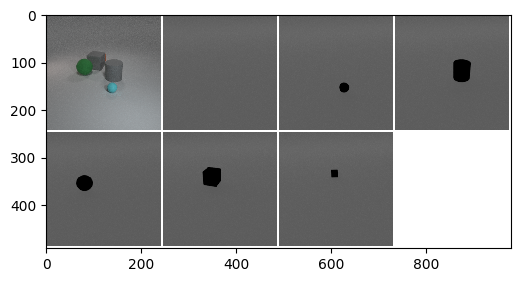

In [109]:
with open(annpath, 'r') as f:
    ann = json.load(f)

img = []
for i in imgpath:
    print(i)
    img.append(cv2.imread(str(i)))
imgs = np.stack(img)
view_image(imgs, 100)

(5, 240, 240)
torch.Size([3, 491, 979])


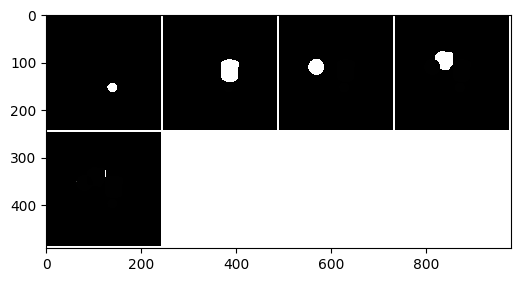

In [110]:
# Note that the procedures below assumes that imgs are already sorted by z depth
# Closer object gets lower index

# Create binary masking of each objects.
subs = imgs.copy()[1:]
n = subs.shape[0]
subs = np.vstack(subs)
subs = cv2.cvtColor(subs, cv2.COLOR_BGR2GRAY)
subs = subs.reshape(n, 240, 240)
subs = subs - np.stack([subs[0]] * n)
mask = subs > 200
subs[mask] = 0
idx = np.where(np.logical_and(subs > 100, subs< 200))
subs[idx] = 255

# Occlusion by objects in front
masks = subs.copy().astype(np.int16)
for i in range(masks.shape[0]-1):
    masks[i+1] -= np.abs(masks[i])
masks = masks.astype(np.uint8)[1:]
view_gray(masks,100)


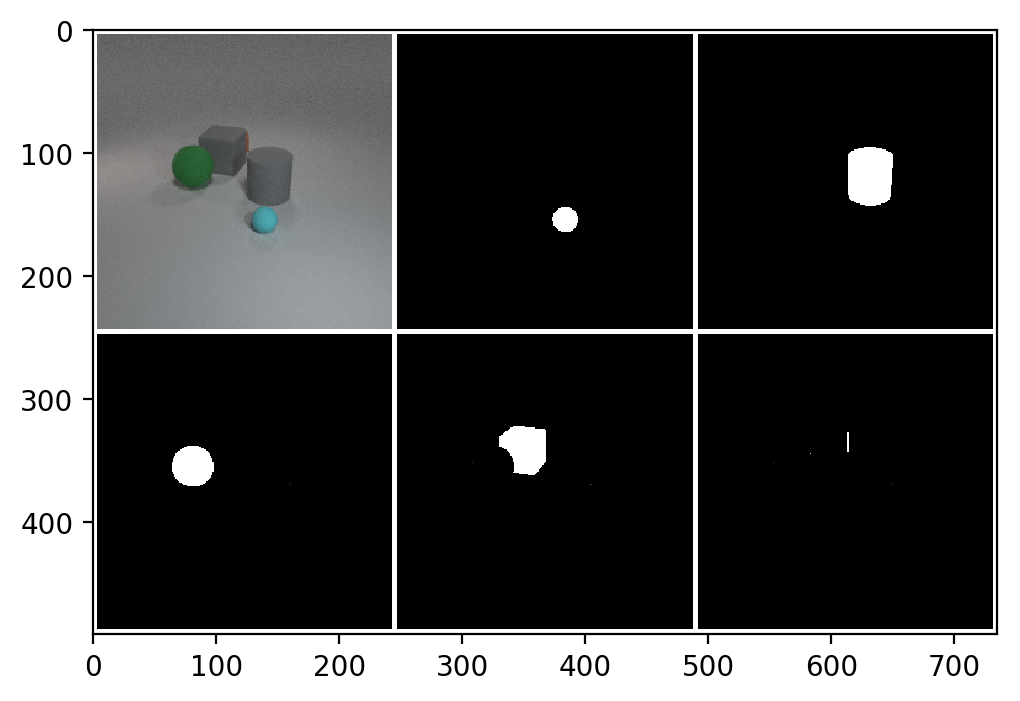

In [111]:
rgb_mask = np.stack([masks] * 3, -1)
full = np.concatenate([np.expand_dims(imgs[0],0), rgb_mask])
view_image(full,200,nrow=3)

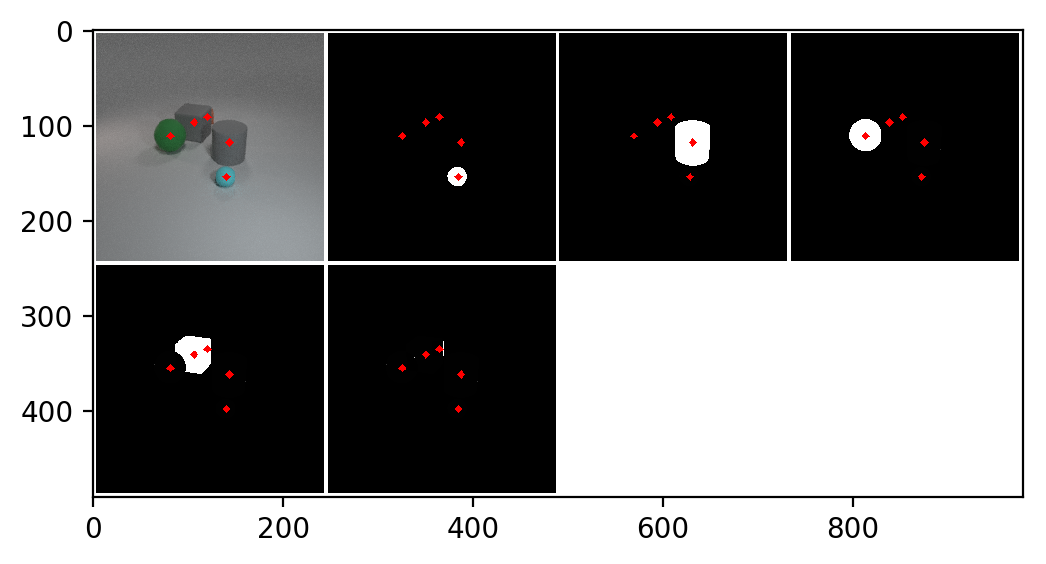

In [112]:
# Object center locations
ii = full.copy()
for a in ann:
    x = a['pixel_coords'][0]
    y = a['pixel_coords'][1]
    for i in ii:
        i = cv2.circle(i, (x, y), 2, (255,0,0), 4)
    #pts = np.array(a['pixel_bbox'])[:,:2].astype(int)
    #tl = (np.min(pts[:,0]), np.min(pts[:,1]))
    #br = (np.max(pts[:,0]), np.max(pts[:,1]))
    #ii = cv2.rectangle(ii, tl, br, (255,0,0), 1)

view_image(ii,200)

In [113]:
for a in ann:
    print(a['shape'], a['pixel_coords'])

sphere [78, 108, 10.717625617980957]
sphere [137, 151, 8.634987831115723]
cube [103, 94, 11.961913108825684]
cylinder [140, 115, 10.125158309936523]
cube [117, 88, 13.608932495117188]


In [115]:
ann

[{'shape': 'sphere',
  'rotation': 250.99853832207444,
  'pixel_bbox': [[60.0, 118.0, 11.38724422454834],
   [56.0, 88.0, 10.723435401916504],
   [89.0, 84.0, 11.188243865966797],
   [91.0, 113.0, 11.852052688598633],
   [66.0, 134.0, 10.247007369995117],
   [63.0, 101.0, 9.583198547363281],
   [99.0, 96.0, 10.048006057739258],
   [101.0, 127.0, 10.71181583404541]],
  'material': 'rubber',
  'pixel_coords': [78, 108, 10.717625617980957],
  'cylinder': [0.9991037249565125, 1.9988852739334106],
  'color': 'green',
  'size': 'large',
  'bbox': [[-1.8232817649841309, -1.8819143772125244, 0.00039011240005493164],
   [-1.8232817649841309, -1.8819143772125244, 1.3996098041534424],
   [-1.371469497680664, -0.5580031275749207, 1.3996098041534424],
   [-1.371469497680664, -0.5580031275749207, 0.00039011240005493164],
   [-0.49950143694877625, -2.33368182182312, 0.00039011240005493164],
   [-0.49950143694877625, -2.33368182182312, 1.3996098041534424],
   [-0.047689229249954224, -1.009770631790161